In [3]:
import json
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import tripy
plt.style.use('classic')

## display the data inside the json, and try to make sense of it (basically reverse engineering the format)

In [4]:
loc="./examples/moonridge.json"
file=open(loc,"r")
data=json.loads(file.read())


In [5]:
print(data['features'][0].keys())
print(data['features'][0]['type'])
print(data['features'][0]['id'])
data["features"][0]

dict_keys(['type', 'id', 'roadWidth', 'towerRadius', 'wallThickness', 'generator', 'version', 'riverWidth'])
Feature
values


{'type': 'Feature',
 'id': 'values',
 'roadWidth': 8,
 'towerRadius': 7.6,
 'wallThickness': 7.6,
 'generator': 'mfcg',
 'version': '0.8.0',
 'riverWidth': 31.357382526694515}

In [6]:
typ=list()
ids=list()
for i in data["features"]:
    typ.append(i["type"])
    ids.append(i["id"])
print(typ)
print(ids)

['Feature', 'Polygon', 'GeometryCollection', 'GeometryCollection', 'GeometryCollection', 'GeometryCollection', 'MultiPolygon', 'MultiPolygon', 'MultiPolygon', 'MultiPolygon', 'MultiPolygon']
['values', 'earth', 'roads', 'walls', 'rivers', 'planks', 'buildings', 'prisms', 'squares', 'greens', 'fields']


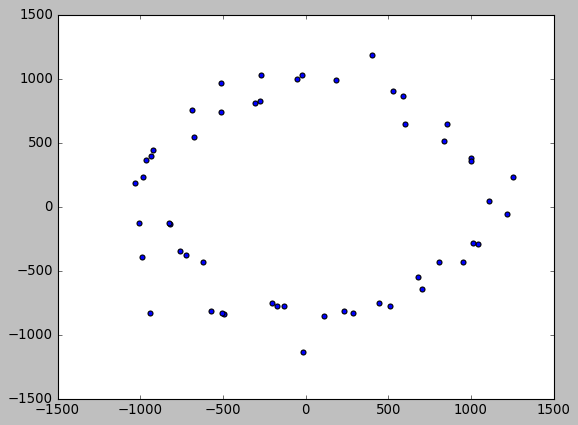

In [7]:
#EARTH
earth=data["features"][1]["coordinates"]
xe,ye=np.array(earth[0]).transpose()
plt.scatter(xe,ye)

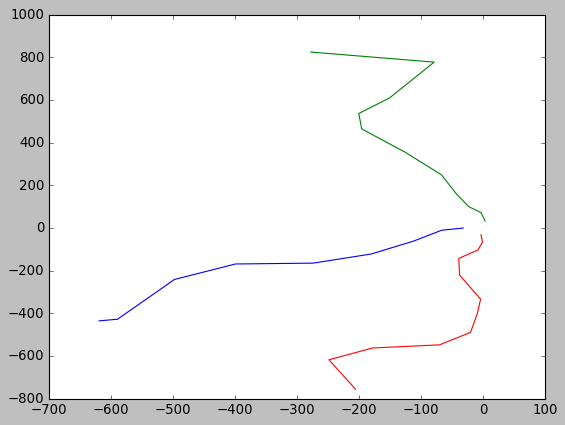

In [8]:
#ROADS
#geometries hold a list of LineStrings
roads=data["features"][2]["geometries"]
for i in range(len(roads)):
    road=roads[i]["coordinates"]
    xr,yr=np.array(road).transpose()
    plt.plot(xr,yr)


In [9]:
#buildings
buildings=data["features"][6]["coordinates"]

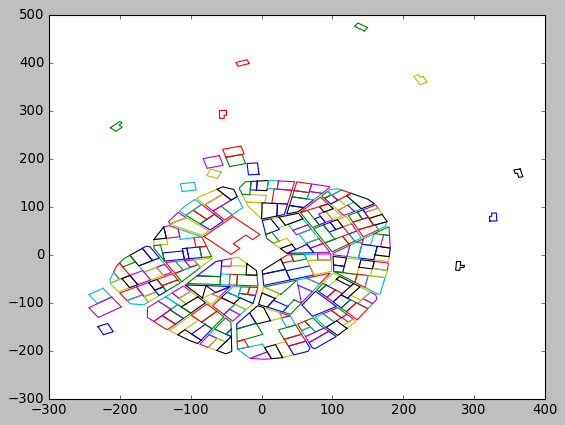

In [10]:
for i in range(len(buildings)):
    x,y=np.array(buildings[i]).transpose()
    x=np.append(x,[x[0]])
    y=np.append(y,[y[0]])

    plt.plot(x,y)

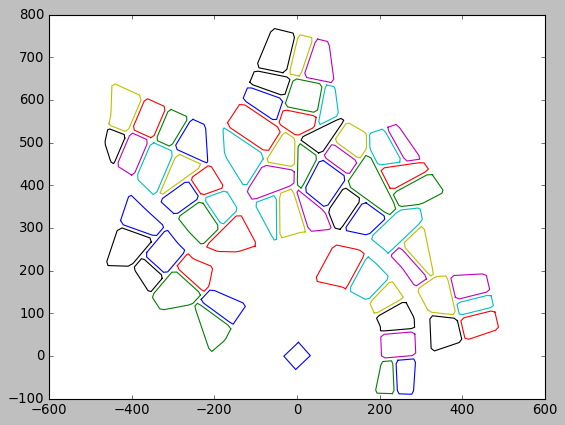

In [11]:
#fields
fields=data["features"][10]["coordinates"]
for i in range(len(fields)):
    x,y=np.array(fields[i][0]).transpose()
    x=np.append(x,[x[0]])
    y=np.append(y,[y[0]])

    
    plt.plot(x,y)
square=data["features"][8]["coordinates"]

for i in range(len(square)):
    x,y=np.array(square[i][0]).transpose()
    x=np.append(x,[x[0]])
    y=np.append(y,[y[0]])

    plt.plot(x,y)


[]
0


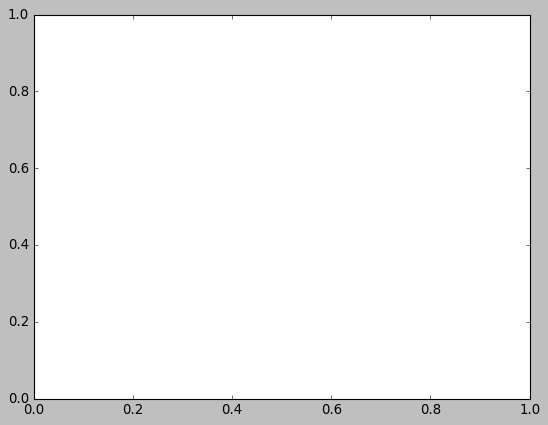

In [12]:
greens=data["features"][9]["coordinates"]
print(greens)
#print(greens[0][0])
fig,ax=plt.subplots(1,1)
print(len(greens))
for i in range(len(greens)):
    x,y=np.array(greens[0][i]).transpose()
    x=np.append(x,[x[0]])
    y=np.append(y,[y[0]])

    
    ax.plot(x,y)
    

[{'type': 'Polygon', 'width': 7.6, 'coordinates': [[[-223.395, -58.383], [-207.854, -10.699], [-162.087, 27.288], [-141.077, 67.251], [-105.224, 117.774], [-42.385, 157.009], [30.075, 162.916], [104.453, 146.869], [162.486, 116.676], [186.454, 64.96], [189.454, -10.696], [172.404, -90.68], [126.134, -162.392], [74.582, -205.673], [18.436, -226.391], [-37.761, -221.534], [-125.785, -174.058], [-180.37, -122.398]]]}]


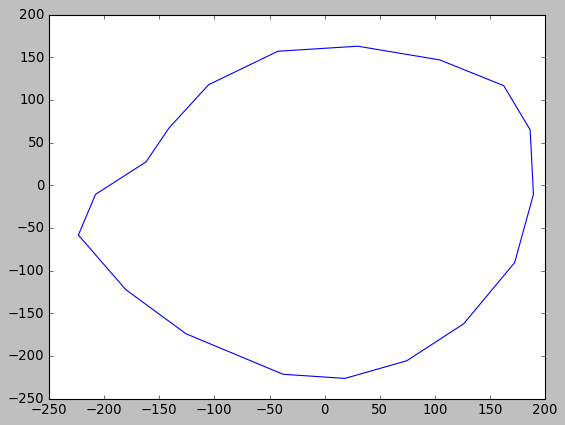

In [13]:
# Walls
# looking at it: the plan is to do the same as with roads
# problem: make openings, make towers
walls=data["features"][3]["geometries"]
print(walls)
for i in range(len(walls)):
    x,y=np.array(walls[i]["coordinates"]).transpose()
    x=np.append(x,[x[0]])
    y=np.append(y,[y[0]])

    plt.plot(x,y)
    

[{'type': 'LineString', 'width': 31.357382526694515, 'coordinates': [[-510.122, 740.068], [-466.19, 652.96], [-469.17, 567.647], [-484.837, 497.979], [-466.279, 442.16], [-401.724, 402.561], [-351.681, 355.741], [-305.702, 314.954], [-275.558, 277.827], [-240.672, 243.59], [-195.946, 225.899], [-141.381, 224.753], [-67.125, 248.657], [11.275, 270.704], [95.261, 279.17], [159.308, 265.959], [203.416, 231.071], [239.507, 194.355], [272.366, 148.702], [301.993, 94.114], [306.29, -1.117], [299.854, -94.581], [282.685, -186.28], [279.942, -241.502], [281.93, -293.679], [288.649, -342.81], [309.162, -400.058], [355.163, -457.338], [426.652, -514.65], [443.564, -754.395]]}]


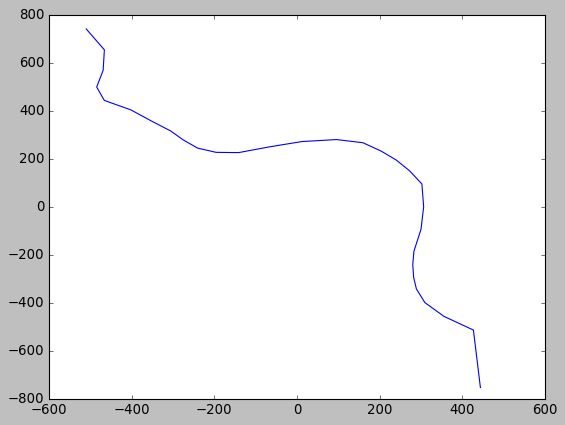

In [14]:
# Walls
# looking at it: the plan is to do the same as with roads
# problem: make openings, make towers
rivers=data["features"][4]["geometries"]
print(rivers)
for i in range(len(rivers)):
    river=rivers[i]["coordinates"]
    xr,yr=np.array(river).transpose()
    plt.plot(xr,yr)
    

In [ ]:
#test: trouver la normale correcte du contour des bâtiments
def normalFromSeg(p0,p1):
    '''
    p1, p2 : points of the segment
    Returns the normal (normalized) of the segment
    if the polygon is written in clockwise order, it's the correct one.
    '''
    dx=p1[0]-p0[0]
    dy=p1[1]-p0[1]
    norm=np.sqrt(dx*dx+dy*dy)
    dx=dx/norm
    dy=dy/norm
    #px=(x1+x0)/2.0
    #py=(y1+y0)/2.0

    #those are inside
    #nx=[px,px-dy]
    #ny=[py,py+dx]
    return [-dy,dx]

def getBuildingNormal(building):
    '''
    building: sequence of points representing the clockwise ordered contour of a building [[x1,x2,x3],[y1,y2,y3]] 
    '''
    x,y=np.array(building).transpose()
    x=np.append(x,[x[0]])
    y=np.append(y,[y[0]])

    fig,ax=plt.subplots()

    skip=True
    x0=0.0
    y0=0.0
    for x1,y1 in zip(x,y):
        if skip:
            x0=x1
            y0=y1
            skip=False
            continue

        #x0y0 - x1y1 is one segment
        dx=x1-x0
        dy=y1-y0
        norm=np.sqrt(dx*dx+dy*dy)
        dx=dx/norm
        dy=dy/norm
        px=(x1+x0)/2.0
        py=(y1+y0)/2.0

        #those are inside
        nx=[px,px-dy]
        ny=[py,py+dx]
        
        x0=x1
        y0=y1
        ax.plot(nx,ny,"red")


    ax.set_aspect('equal', 'box')
    ax.plot(x,y,"teal")
    for tri in tripy.earclip(building):
        ax.plot([tri[0][0],tri[1][0],tri[2][0]],[tri[0][1],tri[1][1],tri[2][1]])
        
getBuildingNormal(buildings[25][0])

In [ ]:

def getSurface(contour,height):
    
    surfacetris=tripy.earclip(contour)
    #this above returns something of the form ( ((1,0),(0,1),(0,0)),((...),...),... )
    #this below converts it to array( [ [1,0,height], [0,1,height], [0,0,height] ],[[...],...]... )
    surface = [np.array([np.append(a,[height]),np.append(b,[height]),np.append(c,[height])]) 
               for a,b,c in surfacetris]
    return surface,np.array([[0,0,1]]*len(surface))
    
def getWalls(contour,height):
    triangles=list()
    normals=list() #each triangle has exactly one norm    
    x,y=np.array(contour).transpose()
    x=np.append(x,[x[0]])
    y=np.append(y,[y[0]])
    z=np.array([0]*len(x))#assume ground is 0
    
    x0,y0,z0=[0,0,0]
    skip=True
    for xi,yi,zi in zip(x,y,z):
        if skip:
            x0,y0,z0=[xi,yi,zi]
            skip=False
            continue
        
        tri1 = np.array([[x0,y0,z0],[xi,yi,height],[xi,yi,zi]])
        tri2 = np.array([[x0,y0,z0],[x0,y0,height],[xi,yi,height]])

        n = np.append(normalFromSeg([x0,y0],[xi,yi]),[height/2])
        triangles.append(tri1)
        triangles.append(tri2)
    
        normals.append(n)
        normals.append(n)
        x0,y0,z0=[xi,yi,zi]
    return triangles,normals

def make3DBuilding(building,height):
    '''
    building: sequence of points representing the clockwise ordered contour of a building [[x1,x2,x3],[y1,y2,y3]]
    (the building as we get it from data has one more [] around it so use [0])
    height: desired height of this building
    '''
    
    
    triangles,normals=getWalls(building,height)
    
    roof,nroof=getSurface(building,height)
    
    
    return {"walls":{"triangles": triangles,"normals":normals},"roof":{"triangles":roof,"normals":nroof}}
    
display(make3DBuilding(buildings[25][0],10))
display("-------------------------------")
display(getSurface(fields[5][0],0))

In [ ]:
roof

In [ ]:
tripy.earclip(buildings[5][0])

In [ ]:
height=10
roof,n=getRoof(buildings[5][0],10)
#center: avg(v1,v2,v3)
print(roof)
c=[ np.average(r,0) for r in roof]

print(c)

In [ ]:
roof[0]

In [ ]:
np.average(roof[0],0)